In [2]:
%%html
<style> table { display: inline-block } </style>

# Image Processor Attempt #1 - Using OpenCV To Read And Identify Key Parts In Images
Mr Nick Havilah (nickhavilah@gmail.com)

| Date | Details|
| :---- | :------ |
| 29/01/2022 | Initial Version |

## Overview

In this attempt, we will use conventional image processing to split a picture of a test license into key sections for processing. We will need to convert it into a black and white image to test its contrast ratios first and see whether that is suitable to identify the numbers and letters on the license. 

Once we get the contrast ratios identified and tweaked for maximum contrast we need to find a way to split the main image into sub images that we can use for further processing.

Each of the sub images(which has a field label and number) will then be split into smaller images that consist of individual numbers so they can be passed into the ML model for further identification. We will need to attempt this same process on the label to identify it. This could be a performance limitation but we will see how it goes.

For the main image on a license(which will be an option we will enable so you can select it to find imges if they exist) we will want it to not be a black and white image so we will need to find a way to increase contrast anyway. Could be risky to identify the section of interest. Then we can use that as a cropping mask and then store the new image of interest as a jpg or something(still to be determined). 

This is the first of the logs. We will make new notebooks for each test and document the progress as we go. This will get uploaded to git and I'll try making a blog of the results as I progress. Will need to write up documentation fully with an analysis of the results afterwards. For now the notebooks will be the main source of progress and data.

In this example we have a look at a Variational Auto-Encoder. This will learn a latent representation, which we can then sample from to generate new samples, i.e. we can use our VAE to 'make up' new data.

Will include the software used as we go and note limitations too.

Run off the python 3.8 module running off windows. For some reason it doesn't play nicely with any other versions (keeps saying its the wrong version)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import argparse
import os, os.path
from os import walk
import cv2
from numpy import sqrt 
import math
import time
import multiprocessing
import csv

import pandas
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from PIL import Image
import pytesseract

ModuleNotFoundError: No module named 'pytesseract'

## Setup and Supporting Functions

Display the test image to verify the system works

Display as a grayscale so we can use that for the rest of the project (for the main bits at least)


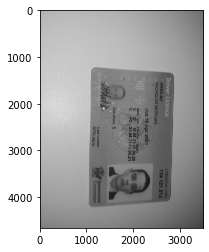

In [4]:
greyscale = cv2.imread('./testimg.jpg', 0) 
plt.imshow(greyscale, cmap='gray')

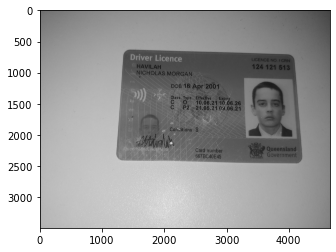

In [5]:
	
greyscale = cv2.imread('./testimg.jpg') 
greyscale = cv2.rotate(greyscale, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
# Obtain the dimensions of the image array
# using the shape method
(row, col) = greyscale.shape[0:2]

# Take the average of pixel values of the BGR Channels
# to convert the colored image to grayscale image
for i in range(row):
    for j in range(col):
        # Find the average of the BGR pixel values
        greyscale[i, j] = sum(greyscale[i, j]) * 0.33
plt.imshow(greyscale)


Here is a colour version of the same image which we will use later in the project for identifying the photo on the license - not super important for now

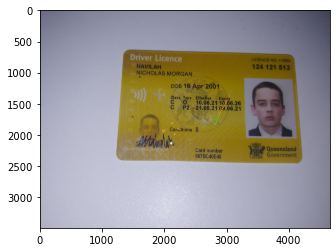

In [6]:
colourscale = mpimg.imread('testimg.jpg')
imgplot = plt.imshow(colourscale)

## Registering Sections

In this section we will start identifying sections by contrast to see how the processor divides the image up

This could have mixed results so we may try several different approaches and see what happens.

First step will be to get an image histogram so we know where the threshold for pixel intensity comes from - this will help us create filters to ditch the background

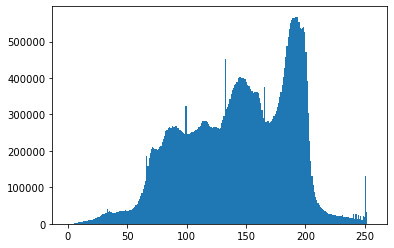

In [7]:
plt.hist(greyscale.ravel(),256,[0,256]); plt.show()

The image greyscale is very grey. We need to convert this to binary in order to interpret the data in a meaningful way(otherwise theres too much noise) About 200 seems to be the threshold of where the best contours will appear - useful for later on when we get contour identification working. Might set a little lower for now though to make sure it only gets the edges we want

It can be noted that when you set it to not have a range and just a specific value that also seems to work well, just not below 100 and not at 255 either. Weird

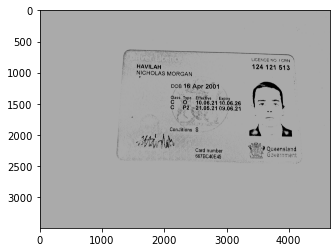

In [8]:
# blur
blur = cv2.GaussianBlur(greyscale, (0,0), sigmaX=40, sigmaY=40)

# divide
divide = cv2.divide(greyscale, blur, scale=255)
(thresh, blackAndWhiteImage) = cv2.threshold(divide,170, 170, cv2.THRESH_BINARY)
plt.imshow(blackAndWhiteImage)
plt.show()


# Feature Extraction

Now that we have binary images with reasonable thresholds (which may need to be tweaked later depending on the results from the next part - the threshold needs to be not too high but not too low in order to filter out the worst of the noise) it is time to create masks for each group of words. This bit will require a custom algorithm to identify key sections by proximity and learn to see only what's necessary. Will need to introduce some custom rules that allow this to reading left to right. 

The biggest challenge will be recognition of tables and how to interpret that data

The easiest way(maybe) will be contour detection, then we can start identifying key parameters to get critical information

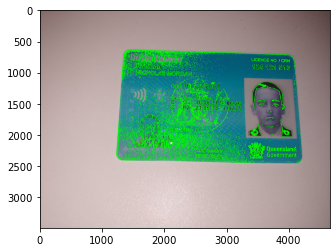

In [9]:
greyscale = cv2.imread('./testimg.jpg') 
greyscale = cv2.cvtColor(blackAndWhiteImage, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(blackAndWhiteImage, 0, 255)
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
plt.imshow(img)
plt.show()

So as seen above, some contours show up great like the license number up the top. The biggest issue is image noise. Its preventing a lot of data from being visible enough that we could draw boundaries around it. Going to need to investigate better denoising techniques. 

The biggest issue with denoising the images is they become simpler as a result. However we are mainly working with text so this isn't a huge concern for this part of the project.

A good one to investigate for noise reduction is blurring algorithms, which we will investigate using in order to see if we can get the best data results. Tho as seen below its pretty good I would say

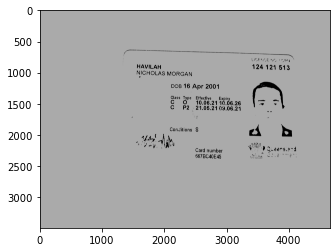

In [10]:
greyscale = cv2.imread('./testimg.jpg') 
greyscale = cv2.rotate(greyscale, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
# Obtain the dimensions of the image array
# using the shape method
(row, col) = greyscale.shape[0:2]

# Take the average of pixel values of the BGR Channels
# to convert the colored image to grayscale image
for i in range(row):
    for j in range(col):
        # Find the average of the BGR pixel values
        greyscale[i, j] = sum(greyscale[i, j]) * 0.33

denoise = cv2.fastNlMeansDenoisingColored(greyscale,None,15,15,7,21)

# blur
blur = cv2.GaussianBlur(denoise, (0,0), sigmaX=40, sigmaY=40)

# divide
divide = cv2.divide(denoise, blur, scale=255)
(thresh, blackAndWhiteImage) = cv2.threshold(divide,170, 170, cv2.THRESH_BINARY)
plt.imshow(blackAndWhiteImage)
plt.show()

As seen below, the contour detection has worked far better than before. The noise has been dramaatically reduced which is really good. The next step is finding a way to group contours together and drawing masks around them so we can see each of the individual sections.

Once we can see the individual sections we will need to develop a method that groups contours together based off proximity. This will need to have a separate method to group clusters together as a table as needed(which will then need to develop the algorithm for different table types which could be difficult)

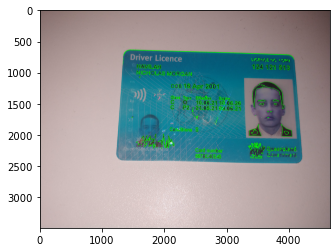

In [11]:
greyscale = cv2.imread('./testimg.jpg') 
greyscale = cv2.cvtColor(blackAndWhiteImage, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(blackAndWhiteImage, 0, 255)
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
plt.imshow(img)
plt.show()

So it seems contour detection is the right approach but there's this thing called agglomerative clustering and might allow us to group the contours together(maybe?)

Tho I think for the purposes of this project we will have to manually develop a clustering algorithm to do this for us. Remember we want it to cluster in specific ways so development may be needed to experiment with this.

First step will be to develop a method for determining the distance between contours

To do this we need to find the approximation of distance between points in each contour and compare them to each other

What we could do is find the distance between points in each contour and create a bounding box around each contour using pythagorous theorem to calculate the width and height between points, and add a buffer so we can draw a reasonably accurate box(maybe 2 pixels extra on each side)

We need to use a sorting algorithm to ensure we organise the highest and lowest distances between points in the contour

In [12]:
def createBoundingBox(contour):
    # minDistance = 9999999999999
    # for point in range(len(contour)-1):
    #     #calculate distance between points
    #     calculatedDistance = sqrt((contour[point+1][0][0]-contour[point][0][0])**2+(contour[point+1][0][1]-contour[point][0][1])**2)
    #     print(calculatedDistance)
    left = 99999999
    right = 0
    top = 99999999
    bottom = 0
    for points in contour:
        for x,y in points:
            if x <= left:
                left = x
            if x >= right:
                right = x
            if y <= top:
                top = y
            if y >= bottom:
                bottom = y
    midpoint = [((right-left)/2)+left,((bottom-top)/2)+top]
    coordinates = [[left,top],[right,bottom],midpoint]
    return coordinates


Currently the midpoint calculations are the biggest limiting factor. Kinda looks like it isnt working the way its supposed to

An easy approach will be find the corners and just go from there? Remember that the letters are fairly consistent in size anyway so shouldn't be too bad I think

Don't try to find the corners actually, find the most extreme values for each side and use those to create bounding boxes. Should be more accurate that way

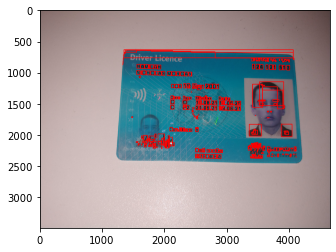

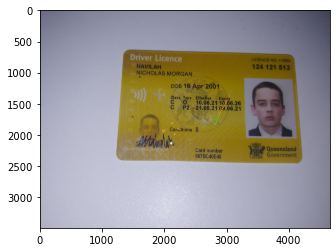

In [13]:
img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
color = (255, 0, 0)
thickness = 10
for contour in contours:
    coordinates = createBoundingBox(contour)
    img = cv2.rectangle(img,coordinates[0],coordinates[1],color,thickness)
plt.imshow(img)
plt.show()
colourscale = mpimg.imread('testimg.jpg')
imgplot = plt.imshow(colourscale)

Now that we found the bounding boxes for every contour, we need to join the ones closest together into bigger more general boxes. There should probably be a general threshold for these things.

Because it generally tends to be words it should be a narrow threshold vertically and a slightly greater threshold horizontally.

Then once we figure out the words we can find a way to group words together too. Maybe another threshold boundary too I would say

In [14]:
def calculatedDistance(p1,p2):
    distance = sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
    return distance

So what we should really be doing is grouping contours based on their bounding boxes, then group those groups togehter(unpack them first and then add them together)

In [15]:
tempArray = []
compiledContours = []
for x in range(len(contours)-1):
    coordinates1 = createBoundingBox(contours[x])
    coordinates2 = createBoundingBox(contours[x+1])
    maxDistance = 2
    if(calculatedDistance(coordinates1[2], coordinates2[2])>=maxDistance):
        tempArray.append(contours[x])
        tempArray.append(contours[x+1])
    else:
        compiledContours.append(tempArray)
        tempArray = []
print(len(compiledContours))


8


In [16]:
def createOverallBoundingBox(contourGroup):
    left = 99999999
    right = 0
    top = 99999999
    bottom = 0
    for contour in contourGroup:
        for points in contour:
            for x,y in points:
                if x <= left:
                    left = x
                if x >= right:
                    right = x
                if y <= top:
                    top = y
                if y >= bottom:
                    bottom = y
    midpoint = [((right-left)/2)+left,((bottom-top)/2)+top]
    coordinates = [[left,top],[right,bottom],midpoint]
    return coordinates

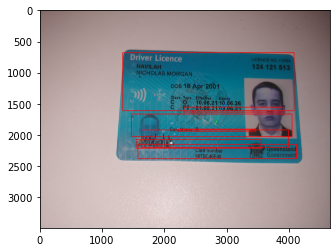

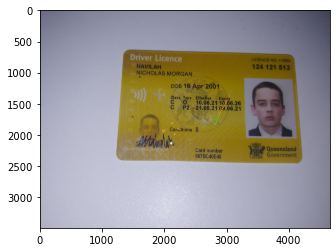

In [17]:
img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
color = (255, 0, 0)
thickness = 10
for contourGroup in compiledContours:
    coordinates = createOverallBoundingBox(contourGroup)
    img = cv2.rectangle(img,coordinates[0],coordinates[1],color,thickness)
plt.imshow(img)
plt.show()
colourscale = mpimg.imread('testimg.jpg')
imgplot = plt.imshow(colourscale)

This approach may not be the easiest way to do this. Lets try first drawing dots and then drawing lines between points. Then if the centre points are within x distance we can try grouping them - this approach may not work however. May need to consult another person on easier ways to do this.

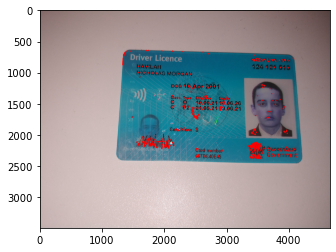

In [18]:
img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
color = (255, 0, 0)
thickness = 10
points = []
for contour in contours:
    coordinates = createBoundingBox(contour)
    points.append(coordinates[2])
    img = cv2.circle(img,(int(coordinates[2][0]),int(coordinates[2][1])), 5, color, thickness)
plt.imshow(img)
plt.show()

Now that we have our list of points, we need to determine the distance between points

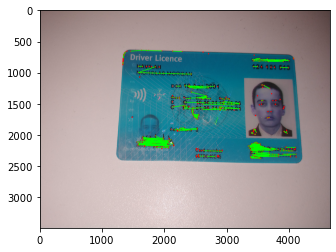

In [19]:
color = (0, 255, 0)
for x in range(len(points)-1):
    # print(math.dist(points[x],points[x+1]))
    if(math.dist(points[x],points[x+1]) < 300):
        # print(math.dist(points[x],points[x+1]))
        img = cv2.line(img, (int(points[x][0]), int(points[x][1])), (int(points[x+1][0]), int(points[x+1][1])), color, thickness)
plt.imshow(img)
plt.show()

So this is kind of useful to have the lines drawn between the midpoints, but this too is the wrong approach. 

What a good approach would be is to go through each midpoint, and draw a horizontal line that goes across the image. 

Then we want to go through the points in the line and see whether any of them is within the bounding box of any of the contours.

If the line does cross through a bounding box, we want to add the contour to a list of aligned contours. 

Then we want to remove that contour from the main list(not essential but would be better for performance).

We then draw a bounding box around this list of contours.

After we add all the contours on that line, we simply add that to a main list. Which we will then iterate over later


Looks like I was wrong. Going to need to find a smarter way to do this. Will be researching ways to group contours together based off distance

An interesting thought would be to write an artificial intelligence algorithm  that groups stuff together through something like kmeans. That might work but will need to investigate this approach further. Would be worth exploring as it is likely to be pretty flexible then and can be applied to different kinds of licenses I think

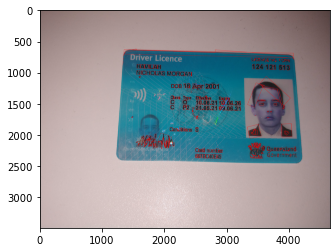

In [20]:
img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)

tempArray = []
boundingBoxes = [cv2.boundingRect(c) for c in contours]
for contour in contours:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img,[box],0,(255,0,0),2)
    tempArray.append(box)
plt.imshow(img)
plt.show()

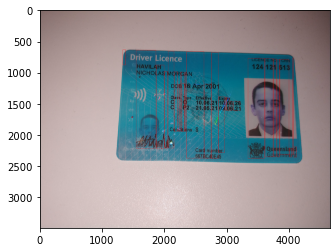

In [21]:
img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
rects = []
usedRects = []
for contour in contours:
    rects.append(cv2.boundingRect(contour))
    usedRects.append(False)

def getXFromRect(item):
    return item[0]

# change it from sorting just left to right to also sort up to down as well. Always helps because the contours need to be grouped based off general position
rects.sort(key = getXFromRect)

acceptedRects = []

xThr = 5
yThr = 5

for supIdx, supVal in enumerate(rects):
    if(usedRects[supIdx] == False):
         # Initialize current rect
        currxMin = supVal[0]
        currxMax = supVal[0] + supVal[2]
        curryMin = supVal[1]
        curryMax = supVal[1] + supVal[3]

        # This bounding rect is used
        usedRects[supIdx] = True

        # Iterate all initial bounding rects
        # starting from the next
        for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

            # Initialize merge candidate
            candxMin = subVal[0]
            candxMax = subVal[0] + subVal[2]
            candyMin = subVal[1]
            candyMax = subVal[1] + subVal[3]

            # Check if x distance between current rect
            # and merge candidate is small enough
            if (candxMin <= currxMax + xThr):

                # Reset coordinates of current rect
                currxMax = candxMax
                curryMin = min(curryMin, candyMin)
                curryMax = max(curryMax, candyMax)

                # Merge candidate (bounding rect) is used
                usedRects[subIdx] = True
            else:
                break

        # No more merge candidates possible, accept current rect
        acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])

for rect in acceptedRects:
    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255,0,0), 2)

plt.imshow(img)
plt.show()

What we seem to have is really good code that organises horizontally. The drawback to this is we have a very complex image with lots of levels. We will need to adapt this code to have a vertical analysis component. Based off the stack overflow code we got this from. This should be promising if we follow the same approach

https://stackoverflow.com/questions/55376338/how-to-join-nearby-bounding-boxes-in-opencv-python

So this shows us is somebody else already wrote better bounding box code, which is fine. This is tighter bounds than before. The next step is to figure out a way to group the bounding boxes together potentially?
That bit might be tricky but the bounding contours we have are far better than before and I think they've grouped the majority of the separate contours together now anyway which is half of what we were trying before.

One of the next steps we will take is to develop the following algorithm:

For each contour in the list of contours
    compare to every other contour
    find the distance between each of the other contours
    if they are within a certain distance we want to add the contour to a temporary array that includes the contour we started with
    sort the contours from left to right and top to bottom
    add the unsorted contour group to an overall list if it unique
check the overall list and make sure there are no duplicates and then draw bounds around the new contour groups
make masks around each contour group to be drawn over the image

Now it's time to work out how to sort contours up to down as well as left to right

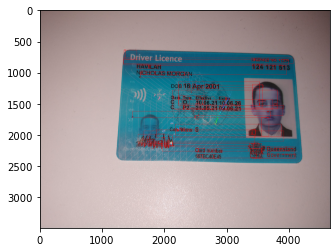

In [22]:
img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
rects = []
usedRects = []
for contour in contours:
    rects.append(cv2.boundingRect(contour))
    usedRects.append(False)

def getXFromRect(item):
    return item[0]

def getYFromRect(item):
    return item[1]

# change it from sorting just left to right to also sort up to down as well. Always helps because the contours need to be grouped based off general position
rects.sort(key=lambda r: [int(75 * round(float(r[1]) / 75)), r[0]])

acceptedRects = []

xThr = 5
yThr = 5

for supIdx, supVal in enumerate(rects):
    if(usedRects[supIdx] == False):
         # Initialize current rect
        currxMin = supVal[0]
        currxMax = supVal[0] + supVal[2]
        curryMin = supVal[1]
        curryMax = supVal[1] + supVal[3]

        # This bounding rect is used
        usedRects[supIdx] = True

        # Iterate all initial bounding rects
        # starting from the next
        for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

            # Initialize merge candidate
            candxMin = subVal[0]
            candxMax = subVal[0] + subVal[2]
            candyMin = subVal[1]
            candyMax = subVal[1] + subVal[3]

            # Check if x distance between current rect
            # and merge candidate is small enough
            if (candxMin <= currxMax + xThr):

                # Reset coordinates of current rect
                currxMax = candxMax
                curryMin = min(curryMin, candyMin)
                curryMax = max(curryMax, candyMax)

                # Merge candidate (bounding rect) is used
                usedRects[subIdx] = True
            else:
                break

        # No more merge candidates possible, accept current rect
        acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])

for rect in acceptedRects:
    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255,0,0), 2)

plt.imshow(img)
plt.show()

A good first attempt at sorting in multiple directions. Still flawed tho. May need to change to a different piece of code to group bounding boxes

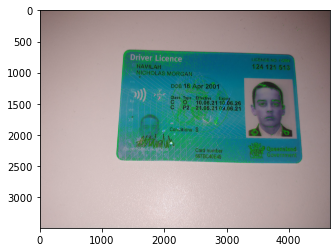

In [23]:
img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
orig = np.copy(img)

def tup(point):
    return (point[0],point[1])

def overlap(source,target):
    tl1, br1 = source
    tl2, br2 = target

    if(tl1[0] >= br2[0] or tl2[0] >= br1[0]):
        return False
    if(tl1[1] >= br2[1] or tl2[1] >= br1[1]):
        return False
    return True

def getAllOverLaps(boxes,bounds,index):
    overlaps = []
    for a in range(len(boxes)):
        if a != index:
            if overlap(bounds,boxes[a]):
                overlaps.append(a)
    return overlaps

greyscale = cv2.imread('./testimg.jpg') 
greyscale = cv2.rotate(greyscale, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
# Obtain the dimensions of the image array
# using the shape method
(row, col) = greyscale.shape[0:2]

# Take the average of pixel values of the BGR Channels
# to convert the colored image to grayscale image
for i in range(row):
    for j in range(col):
        # Find the average of the BGR pixel values
        greyscale[i, j] = sum(greyscale[i, j]) * 0.33
# blur
blur = cv2.GaussianBlur(greyscale, (0,0), sigmaX=40, sigmaY=40)

# divide
divide = cv2.divide(greyscale, blur, scale=255)
(thresh, blackAndWhiteImage) = cv2.threshold(divide,170, 170, cv2.THRESH_BINARY)
greyscale = cv2.imread('./testimg.jpg') 
greyscale = cv2.cvtColor(blackAndWhiteImage, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(blackAndWhiteImage, 0, 255)
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

boxes = []
hierarchy = hierarchy[0]
for component in zip(contours, hierarchy):
    currentContour = component[0]
    currentHierarchy = component[1]
    x,y,w,h = cv2.boundingRect(currentContour)
    if(currentHierarchy[3] < 0):
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1)
        boxes.append([[x,y],[x+w, y+h]])

filtered = []
max_area = 10000
for box in boxes:
    w = box[1][0] - box[0][0]
    h = box[1][1] - box[0][1]
    if(w*h < max_area):
        filtered.append(box)
boxes = filtered

merge_margin = 20

finished = False
highlight = [[0,0], [1,1]]
points = [[[0,0]]]
while not finished:
    finished = True

    key = cv2.waitKey(1)
    if(key == cv2.waitKey(1)):
        break

    index = 0
    while index < len(boxes):
        curr = boxes[index]

        tl = curr[0][:]
        br = curr[1][:]
        tl[0] -= merge_margin
        tl[1] -= merge_margin
        br[0] -= merge_margin
        br[1] -= merge_margin

        overlaps = getAllOverLaps(boxes, [tl,br], index)

        if(len(overlaps) > 0):
            con = []
            overlaps.append(index)
            for ind in overlaps:
                tl,br = boxes[ind]
                con.append([tl])
                con.append([br])
            con = np.array(con)

            x,y,w,h = cv2.boundingRect(con)

            w -= 1
            h -= 1
            merged = [[x,y], [x+w,y+h]]

            highlight = merged[:]
            points = con
            overlaps.sort(reverse = True)
            for ind in overlaps:
                del boxes[ind]
            boxes.append(merged)

            finished = False
            break

        index += 1

cv2.destroyAllWindows()

copy = np.copy(orig)
for box in boxes:
    cv2.rectangle(copy,tup(box[0]),tup(box[1]),(0,200,0),1)
plt.imshow(copy)
plt.show()

Currently this method has promise, it has something to do with the image processing I think. May need to revisit certain parts of the code because it isn't bounding boxes properly and it could be part of the threshold issues. We will need to experiment more with this code. It is also kinda slow so will need to see what we can do about running in parallel. 

https://www.onooks.com/how-to-merge-neighboring-bounding-boxes/

A big issue with this approach however is that its too sensitive - it's picking up the hologram on the license. I think we will need to go back to the original approach of grouping centrepoints together and give that a shot. We will need to confirm the centrepoint algorithm works correctly however

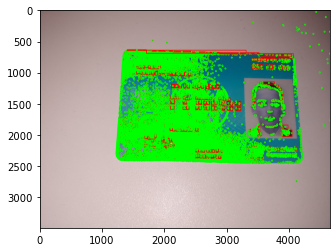

In [24]:
img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
color = (255, 0, 0)
thickness = 10
for contour in contours:
    coordinates = createBoundingBox(contour)
    img = cv2.rectangle(img,coordinates[0],coordinates[1],color,thickness)
    img = cv2.circle(img,(int(coordinates[2][0]),int(coordinates[2][1])),10,(0,255,0),thickness)
plt.imshow(img)
plt.show()

So we have confirmed the midpoints appear to be working correctly. Let's see if we can try grouping these bloody things properly for once

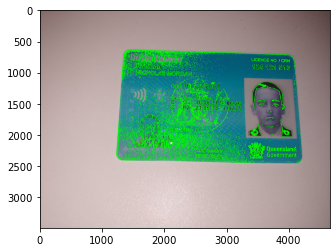

In [25]:
greyscale = cv2.imread('./testimg.jpg') 
greyscale = cv2.cvtColor(blackAndWhiteImage, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(blackAndWhiteImage, 0, 255)
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
plt.imshow(img)
plt.show()

Perhaps it will be easier to start from just the contours and group them together first if they are within a certain distance of each other

In [26]:
img = cv2.imread('./testimg.jpg') 
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
for contour in contours:
    moment = cv2.moments(contour)
    cX = int(moment["m10"] / moment["m00"])
    cY = int(moment["m01"] / moment["m00"])
    img = cv2.circle(img,(cX,cY),10,(0,255,0),thickness)
plt.imshow(img)
plt.show()   

ZeroDivisionError: float division by zero

Contour detection is the wrong approach for the problem. I think a better approach that will be more generalised is to develop a machine learning algorithm. The hardest part is going to be getting sufficient images to train the algorithm. We will need to provide a unique series of annotations for the project. Here is what we need to generate:
- 12000 images
    - 2000 images of a mix of driver's licenses (front and back) from different angles and lighting modes
    - 4000 images of a different assortment of licenses - blue cards, forklift tickets, membership cards, anything with data on it that will help the model recognise the text - will need to have a mix of light and dark licenses
    - 4000 images of licenses being held in hands - should be a mix of different coloured hands in a bunch of different positions and lighting modes
    - 2000 images of licenses that have text partially eclipsed

Annotations
- Should be a text description of the license with the following format:
    - "Type: Driver's License, License Number: 120390876, ...." for every feature on the license that is visible
    - This way we can split the data by comma and then by colon as well when necessary

Will need to do some image preparation but that will come after the dataset is actually made

# Some Thoughts On Performance

So it can already be seen that converting the image to grayscale from the start is taking around a minute and a half. Doesn't sound like much but this could impact the user experience in the end.

One potential solution is to develop a masking method that crops everything out except for the main license - which could save on performance - will need to investigate further

The other big issue is depending on the license layouts, we may struggle with having a model flexible enough to deal with various license types. The layout of information on the license could cause us some problems that we will need to look into - may have to collect data about license layouts from a variety of different sources. This could also be alleviated with a flexible algorithm design too. Currently the plan is to identify words and then we can go from there to identify data tables too

As seen above, signature detection could cause issues but we might be able to develop a threshold to add padding around that signature, then create a mask around it for cropping then store the image. This could work but ultimately this may cause issues for performance - may have to look into GPU acceleration for image processing almost? 

Once we crop the main boundaries for the license it could be easier to detect images. As seen above it does struggle with contour detection around the license - may need to investigate low level thresholds alternatively maybe

Furthermore we also need to find a way to identify white text too. Not super important cos the main details are in black but the algorithm should be adapatable for different types of licenses

So currently accuracy appears to be pretty good. However it may not be sufficient. We will have to see what happens with the combined bounding boxes. I think we will need to find ways to filter out some of the other details too. That remains to be seen I think

# Guys We Did It Wrong Before! This Time, We're Hopefully Gonna Do It Right

So to save a bunch of time on the data collection stage, we are gonna try a little bit of sneaky programming. The trick will be to get some new videos of licenses, and convert frames of videos into images. Fortunately for us, opencv already has this functionality built in. 

In [28]:
video = cv2.VideoCapture('./videos/testvid.mp4')
i=0
DIR = './snapshots'
while(video.isOpened()):
    ret, frame = video.read()
    if ret == False:
        break
    filename = 'snapShot' + str(i) + '.jpg'
    cv2.imwrite(os.path.join(DIR,filename),frame)
    i+=1
video.release()

KeyboardInterrupt: 

Alrighty so we have confirmed that a 12 second video yields about 375 ish pictures, which means the camera is shooting at about 30fps. Useful to know. The next step is to loop through a series of videos in a directory to generate data from a variety of images

In [ ]:
DIR = './videos'
fileCount = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
print(fileCount)
filenames = next(walk(DIR), (None, None, []))[2]  # [] if no file
for file in filenames:
    print('./'+file)

Alrighty so we have now figured out how to list files in a directory, which we will use to iterate through and create new data as we need to

In [ ]:
pull_dir = './videos'
push_dir = './snapshots'
i=0
t = time.time()
filenames = next(walk(pull_dir), (None, None, []))[2]  # [] if no file
for file in filenames:
    video = cv2.VideoCapture('./videos/'+file)
    while(video.isOpened()):
        ret, frame = video.read()
        if ret == False:
            break
        filename = 'snapShot' + str(i) + '.jpg'
        cv2.imwrite(os.path.join(push_dir,filename),frame)
        i+=1
    video.release()
print(time.time() - t)  

So we have figured out how to loop through videos to store the images. Which is a super useful part of the code. The next step will be to develop ways to parallelise the code to run it even faster

In [29]:
pull_dir = './videos'
push_dir = './snapshots'
filenames = next(walk(pull_dir), (None, None, []))[2]  # [] if no file

In [30]:
def getSnapshots(file):
    i=0
    video = cv2.VideoCapture('./videos/'+file)
    while(video.isOpened()):
        ret, frame = video.read()
        if ret == False:
            break
        filename = 'snapShot' + str(i) + '.jpg'
        cv2.imwrite(os.path.join(push_dir,filename),frame)
        i+=1
    video.release()

In [31]:
for file in filenames:
    getSnapshots(file)

In [32]:
for x in range(len(filenames)):
    getSnapshots(filenames[x])

So the results are in. Not worth parallelising. We are now ready for data collection. For now will focus on finding an efficient way to annotate data. An easier way to do it is to write the information once, and then call it inside the loop we're making

In [33]:
with open('./notes/test.txt') as f:
    lines = f.readlines()
    print(lines)

['reeeeeee']


In [34]:
with open('./img_annotations.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    # write the data
    writer.writerow(["data"])
    writer.writerow(["test"])

Now that we worked out how to get this bit working to export to csv. We will now work out how to loop through each of the notes in the file. Will probably switch to using an index based iteration so we can read from 2 separate subdirectories

In [36]:
vid_dir = './videos'
snapshot_dir = './snapshots'
note_dir = './notes'
i=0
t = time.time()

videos = next(walk(vid_dir), (None, None, []))[2]  # [] if no file
notes = next(walk(note_dir), (None, None, []))[2]  # [] if no file

with open('./img_annotations.csv', 'w+', encoding='UTF8', newline='') as annotation_file:
    writer = csv.writer(annotation_file)
    for x in range(len(videos)):
        line = ''
        with open('./notes/'+notes[x]) as note:
            lines = note.readlines()

        video = cv2.VideoCapture('./videos/'+videos[x])
        while(video.isOpened()):
            ret, frame = video.read()
            if ret == False:
                break
            filename = 'snapShot' + str(i) + '.jpg'
            cv2.imwrite(os.path.join(snapshot_dir,filename),frame)
            writer.writerow(lines)
            i+=1
        video.release()
print(time.time() - t) 

19.075687885284424


Alrighty so we now have a means to generate notes for annotating the data. The trick is to make sure the position of the notes in the folder is the same position as the videos in that folder. This will ensure the data is generated correctly and we don't have any issues

So it takes a little under twice the time of the input video to get all the snapshots and annotate it, which isn't terrible. It's going to take time and that's fine. It was already going to be like that unfortunately. That's just part of the nature of machine learning. The upside is a more robust model and having streamlined this process it will go faster than manually collecting all of the data as well

One limitation is that adding new data to the training mix may cause a few issues but once we get the data just leave it be. Shouldn't cause too many issues

# Now That We Have Our Training Data Collection Setup, Let's Try To Setup Making More Training Data From The Existing Training Data Using Data Manipulation Methods
I think it's going to make more sense to add even more data, because we are going to be making a complex model that is going to have to generate a lot of data. *Note To Self: It's Called Data Augmentation*

Here's the checklist of different styles of images we are going to generate:
- different colour tinges to the images
- different contrast levels
- even more angles
- flipping the images horizontally and vertically
- translations

This should be enough to probably get us to the stage of nearly a million images and data points

First step is to turn the data we have into a proper dataset that we can use to generate more data with

In [ ]:
# I have some old notes I'll need to dig up that should be perfect for this situation
# latest item in the downloads section

In [37]:
data = pandas.read_csv('./img_annotations.csv')
print(data)

     reeeeeee
0    reeeeeee
1    reeeeeee
2    reeeeeee
3    reeeeeee
4    reeeeeee
..        ...
370  reeeeeee
371  reeeeeee
372  reeeeeee
373  reeeeeee
374  reeeeeee

[375 rows x 1 columns]


First we are going to split the data into training and testing sets. We'll go with the traditional 80-20 split of training-test data. Then we can split the test set in half to be testing and validation data

In [38]:
# first calculate what 20% of the data looks like
test_amount = round(len(data)*0.2,0)
test_set_ints = random.sample(range(len(data)),int(test_amount))
training_set_ints = range(0,len(data))
training_set_ints = list(set(training_set_ints)-set(test_set_ints))

training_imgs = []
training_notes = []

testing_imgs = []
testing_notes = []

img_dir = "./snapshots"
images = next(walk(img_dir), (None, None, []))[2]  # [] if no file
data = np.array(data)
# make the training set
for x in training_set_ints:
    training_notes.append(data[x])
    img = cv2.imread('./snapshots/'+images[x])
    training_imgs.append(img)

# make the testing set
for x in test_set_ints:
    testing_notes.append(data[x])
    img = cv2.imread('./snapshots/'+images[x])
    testing_imgs.append(img) 

x_train = np.array(training_imgs)
y_train = np.array(training_notes)
x_test = np.array(testing_imgs)
y_test = np.array(testing_notes)

Ok cool, so we have divided the data into training and testing sets. For now, let's focus on adding data augmentation to the model

In [39]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(300, 1080, 1920, 3)
(300, 1)
(75, 1080, 1920, 3)
(75, 1)


Stolen from some other notes - will need to be worked on but we have exactly what we need I would say

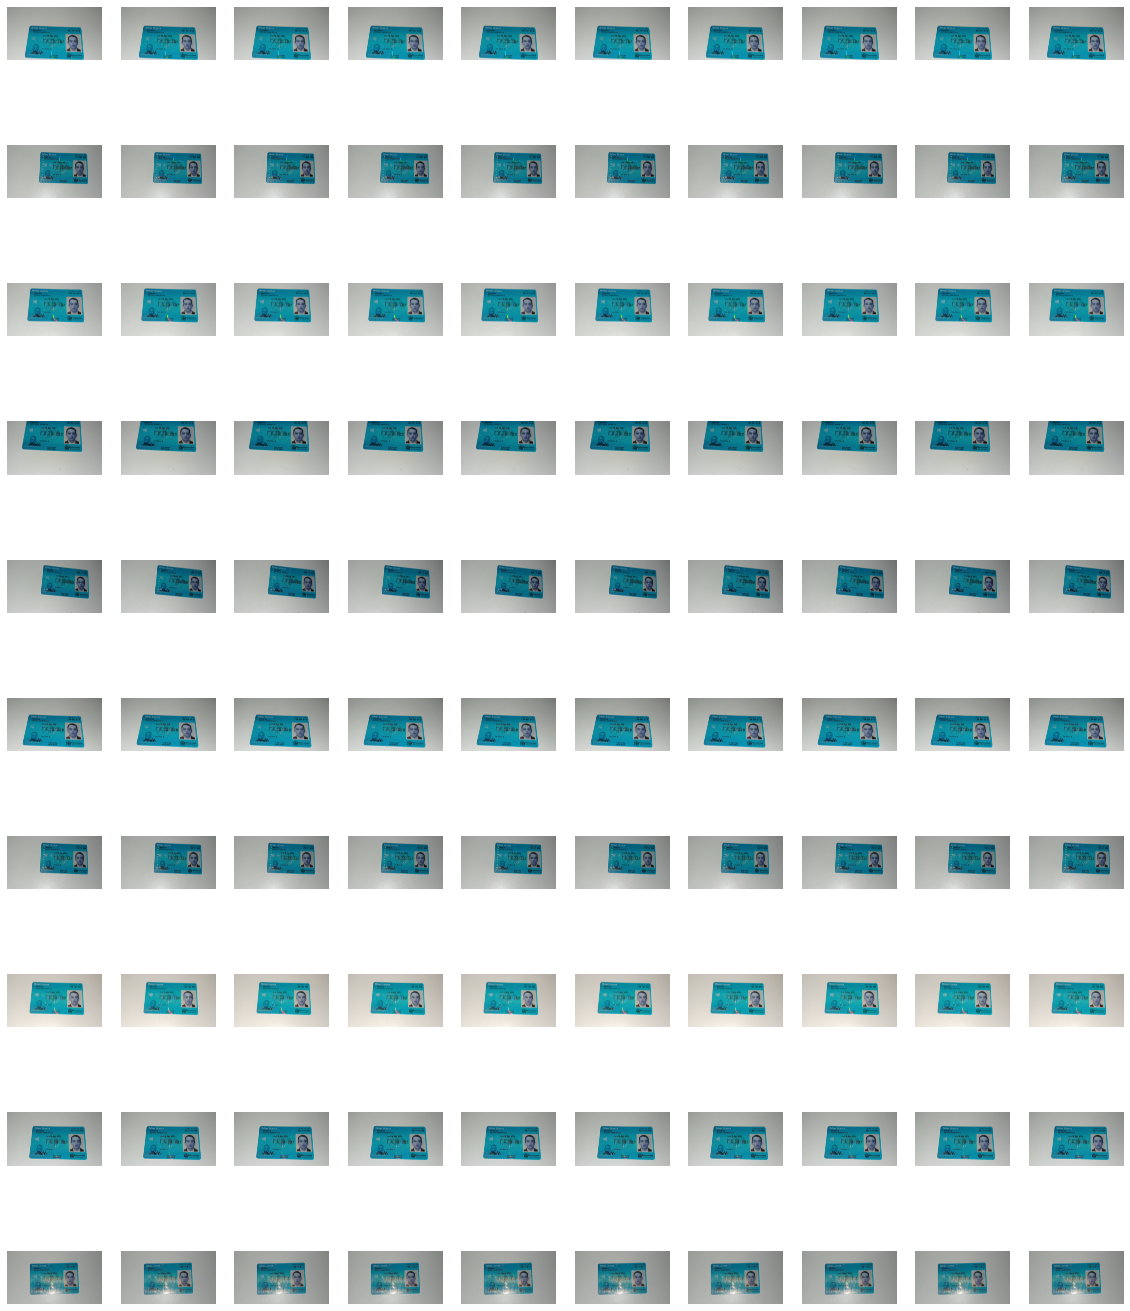

In [40]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomFlip("vertical"),
  layers.experimental.preprocessing.RandomRotation(0.05),
  layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025))
])

fig = plt.figure(figsize=[20, 25])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(x_train[i,:,:,:],0))
        plt.imshow(augmented_image[0])
        plt.axis("off")

Now that we have data setup, we need to choose a data model. There are a couple of different models we could choose from. This is going to be supervised training as we have very specific outcomes we want and the best way is to make supervised models for it. Here is the list and their advantages and disadvantages:
- CNN
    - highly trainable and configurable
- OCR
    - built specifically for text recognition
- Detecting text object models
    - Also an extended CNN essentially
- Multi-Task Network For Text Extraction
    - uses multiple sub networks to train on different subsets of data and compares them against each other?
Info sourced from https://medium.com/capital-one-tech/learning-to-read-computer-vision-methods-for-extracting-text-from-images-2ffcdae11594

Multi task does not look fully appropriate for our purposes. Should probably avoid

So OCR is the best approach to use for this project as it works quite well for unstructured text like what we would expect on a license. There's already a library for this called Tesseract, so we will try and get this working and see what the results are like

In [ ]:
img = cv2.imread('./snapshots/snapShot0.jpg')